Los modelos lineales son fundamentales tanto en estadística como en el aprendizaje automático, pues muchos métodos se apoyan en la combinación lineal de variables que describen los datos. Lo más sencillo será ajustar una línea recta con `LinearRegression`, pero veremos que contamos con un abaníco mucho más grande de herramientas.

Para mostrar cómo funcionan estos modelos vamos a emplear uno de los dataset que ya incorpora `scikit-learn`.

In [1]:
from sklearn import datasets
boston = datasets.load_boston()

El Boston dataset es un conjunto de datos para el análisis de los precios de las viviendas en la región de Boston. Con `boston.DESCR` podemos obtener una descripción del dataset, con información sobre el mismo, como el tipo de atributos.

In [2]:
print(boston.DESCR)

Boston House Prices dataset

Notes
------
Data Set Characteristics:  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive
    
    :Median Value (attribute 14) is usually the target

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pupil-teacher ratio by town
      

Vemos que tenemos 506 muestras con 13 atributos que nos ayudarán a predecir el precio medio de la vivienda. Ahora bien, no todos los atributos serán significativos ni todos tendrán el mismo peso a la hora de determinar el precio de la vivienda; pero eso es algo que iremos viendo conforme adquiramos experiencia e intuición.

## LinearRegression

Ya tenemos los datos, vamos a ajustar una línea recta para ver cuál es la tendencia que siguen los precios en función del atributo.

Lo primero es importar `LinearRegression` y crear un objeto.

In [3]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression(normalize=True)

Una vez tenemos claro el modelo a emplear, el siguiente paso es entrenarlo con los datos de variables independientes y variables dependientes que tenemos. Para ello, en scikit-learn tenemos funciones del tipo:
    
    modelo.fit(X, y)

In [4]:
lr.fit(boston.data, boston.target)

LinearRegression(copy_X=True, fit_intercept=True, normalize=True)

Éste, al tratarse de un modelo sencillo y con muy pocas muestra tardará muy poco en entrenarse. Una vez completado el proceso podemos ver los coeficientes que ha asignado a cada atributo y así ver de qué manera contribuyen al precio final de la vivienda.

In [5]:
for (feature, coef) in zip(boston.feature_names, lr.coef_):
    print('{:>7}: {: 9.5f}'.format(feature, coef))

   CRIM:  -0.10717
     ZN:   0.04640
  INDUS:   0.02086
   CHAS:   2.68856
    NOX: -17.79576
     RM:   3.80475
    AGE:   0.00075
    DIS:  -1.47576
    RAD:   0.30566
    TAX:  -0.01233
PTRATIO:  -0.95346
      B:   0.00939
  LSTAT:  -0.52547


Con esto ya tendríamos una pequeña idea de cuales son los factores que más contribuyen a incrementar o disminuir el precio de la vivienda. Pero no vayamos a sacar conclusiones precipitadas como han hecho en su día [Reinhart y Rogoff](http://www.bbc.com/news/magazine-22223190) y visualicemos los datos primero.

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

In [7]:
def plot_feature(feature):
    f = (boston.feature_names == feature)
    plt.scatter(boston.data[:,f], boston.target, c='b', alpha=0.3)
    plt.plot(boston.data[:,f], boston.data[:,f]*lr.coef_[f] + lr.intercept_, 'k')
    plt.legend(['Predicted value', 'Actual value'])
    plt.xlabel(feature)
    plt.ylabel("Median value in $1000's")

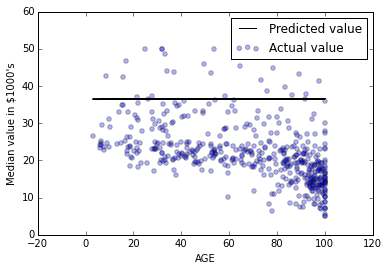

In [8]:
plot_feature('AGE')

En este caso hemos representado el precio medio la vivienda frente a la proporción de viviendas anteriores a 1940 que hay en la zona. Y como poder ver cláramente, emplear sólo un parámetro (AGE) para determinar el precio de la vivienda mediante una línea recta no parece lo ideal. Pero si tomamos en cuenta todas las variables las predicciones posiblemente mejoren.

Por tanto vamos a utilizar el modelo ya entrenado para predecir los precios de las viviendas. Aunque en este caso no vamos a utilizar datos nuevos, sino los mismos datos que hemos empleado para entrenar el modelo y así ver las diferencias.

In [9]:
predictions = lr.predict(boston.data)

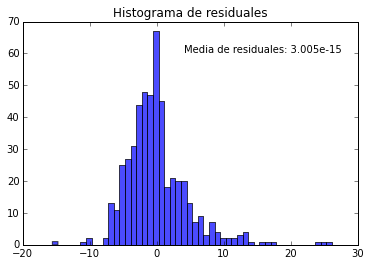

In [10]:
f, ax = plt.subplots(1)

ax.hist(boston.target - predictions, bins=50, alpha=0.7)
ax.set_title('Histograma de residuales')
ax.text(0.95, 0.90, 'Media de residuales: {:.3e}'.format(np.mean(boston.target - predictions)),
        transform=ax.transAxes, verticalalignment='top', horizontalalignment='right')

Podemos ver que el error medio es despreciable y que la mayoría de los valores se concentran entorno al 0. Pero, ¿cómo hemos llegado a esos valores?

La idea detrás de la regresión lineal es encontrar unos coeficientes $\beta$ que satisfagan 

$$y = X\beta,$$

donde $X$ es nuestra matriz de datos e $y$ son nuestros valores objetivo. Puesto que es muy poco probable que a partir de nuestros valores de $X$ obtengamos los coeficientes que plenamente satisfagan la ecuación, es necesario añadir un término de error $\varepsilon$, tal que

$$y = X\beta + \varepsilon.$$

Con el fin de obtener ese conjunto de coeficientes $\beta$ que relacionan $X$ con $y$, `LinearRegression` recurre al método de mínimos cuadrados

$$\underset{\beta}{min\,} {|| X \beta - y||_2}^2.$$

Para éste problema también existe una solución analítica,

$$\beta = (X^T X)^{-1}X^Ty,$$

pero, ¿qué ocurre si nuestros datos no son independientes? En ese caso, $X^T X$ no es invertible y si contamos con columnas que son función de otras, o están de alguna manera correlacionadas, la estimación por mínimos cuadrados se vuelve altamente sensible a errores aleatorios incrementándose la varianza.

### Regularización

Para esos casos emplearemos el modelo `Ridge` que añade un factor de regularización $\alpha$ que en español se conoce como [factor de Tíjinov](http://es.wikipedia.org/wiki/Regularización_de_Tíjonov).

$$\underset{\beta}{min\,} {{|| X \beta - y||_2}^2 + \alpha {||\beta||_2}^2},$$

y así la solución analítica queda como

$$\beta = (X^T X + \alpha^2I)^{-1}X^Ty.$$

Veamos un ejemplo. Para ello, en vez de cargar un dataset crearemos nosotros uno con tres atributos, y donde sólo dos sean linealmente independientes. Para ello utilizamos la función [`make_regression`](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_regression.html).

In [11]:
from sklearn.datasets import make_regression
reg_data, reg_target = make_regression(n_samples=2000, n_features=3, effective_rank=2, noise=10)

Nos interesará también optimizar el valor de $\alpha$. Eso lo haremos con la validación cruzada mediante el objeto [`RidgeCV`](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeCV.html) que emplea una técnica similar al *leave-one-out cross-validation* (LOOCV), i.e., dejando uno fuera para test mientras entrena con el resto de las muestras.

In [12]:
from sklearn.linear_model import RidgeCV

A la hora de crear el objeto le vamos a indicar los valores de $\alpha$ a evaluar. También guardamos los datos que obtenemos al realizar la validación cruzada con `store_cv_values=True` para representarlos gráficamente.

In [13]:
alphas = np.linspace(0.01, 0.5)

rcv = RidgeCV(alphas=alphas, store_cv_values=True)
rcv.fit(reg_data, reg_target)

RidgeCV(alphas=array([ 0.01,  0.02,  0.03,  0.04,  0.05,  0.06,  0.07,  0.08,  0.09,
        0.1 ,  0.11,  0.12,  0.13,  0.14,  0.15,  0.16,  0.17,  0.18,
        0.19,  0.2 ,  0.21,  0.22,  0.23,  0.24,  0.25,  0.26,  0.27,
        0.28,  0.29,  0.3 ,  0.31,  0.32,  0.33,  0.34,  0.35,  0.36,
        0.37,  0.38,  0.39,  0.4 ,  0.41,  0.42,  0.43,  0.44,  0.45,
        0.46,  0.47,  0.48,  0.49,  0.5 ]),
    cv=None, fit_intercept=True, gcv_mode=None, loss_func=None,
    normalize=False, score_func=None, scoring=None, store_cv_values=True)

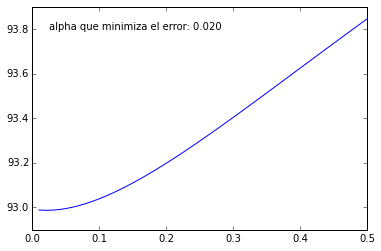

In [14]:
plt.rc('text', usetex=False)
f, ax = plt.subplots()

ax.plot(alphas, rcv.cv_values_.mean(axis=0))
ax.text(0.05, 0.90, 'alpha que minimiza el error: {:.3f}'.format(rcv.alpha_),
        transform=ax.transAxes)

Con `rcv.alpha_` obtenemos el valor de $\alpha$ que nuestro que nuestro método `RidgeCV` ha considerado minimiza el error, lo cual también acamos de comprobar gráficamente.

Pero métodos para regresión lineal hay muchos, y en la [documentación de scikit-learn](http://scikit-learn.org/stable/modules/linear_model.html#) podréis encontrar una descripción bastante completa de cada alternativa.

## Regresión no lineal

Ahora bien, ¿qué hacer cuando la relación no es lineal y creemos que un polinomio haría un mejor ajuste? Si tomamos como ejemplo una función $f$ que toma la forma

$$f(x) = a + bx + cx^2 $$

la función $f$ es no lineal en función de $x$ pero si es lineal en función de los parámetros desconocidos $a$, $b$, y $c$. O visto de otra manera: podemos sustituir nuestras variables $x$ por un array $z$ tal que

$$ z = [1, x, x^2] $$

con el que podríamos reescribir nuestra función $f$ como

$$ f(z) = az_0 + bz_1 + cz_2$$

Para ello en `scikit-learn` contamos con la herramienta [`PolynomialFeatures`](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html). Veamos un ejemplo.

En este caso vamos a tomar la función *seno* entre 0 y 2$\pi$ a la que añadiremos un poco de ruido.

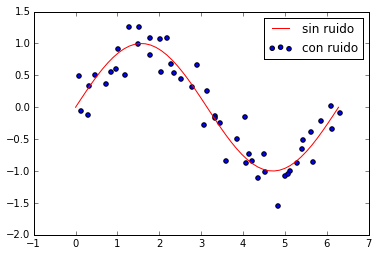

In [15]:
f, ax = plt.subplots()

x = np.linspace(0, 2*np.pi)
y = np.sin(x)
ax.plot(x, np.sin(x), 'r', label='sin ruido')
# añadimos algo de ruido
xr = x + np.random.normal(scale=0.1, size=x.shape)
yr = y + np.random.normal(scale=0.2, size=y.shape)
ax.scatter(xr, yr, label='con ruido')
ax.legend()

In [16]:
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

Scikit-learn tiene un objeto [`PolynomialFeatures`](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html) que nos va a servir para convertir nuestra variable $x$ en un array $z$ del tipo $z = [1, x, x^2, \ldots, n^n]$, que es lo que nos interesa.

El resultado de esa transformación se la pasamos a nuestro modelo `Ridge`. Para facilitar la tarea en este tipo de casos —donde se realizan varios pasos que van desde el pre-tratamiento de los datos hasta un posible post-tratamiento pasando por el entrenamiento—, podemos hacer uso de las [`Pipeline`](http://scikit-learn.org/stable/modules/pipeline.html) que nos permiten encadenar multiples estimadores en uno. Esto es especialmente útil cuando hay secuencia de pasos predefinidos en el procesado de datos con, por ejemplo, selección de atributos, normalización y clasificación.

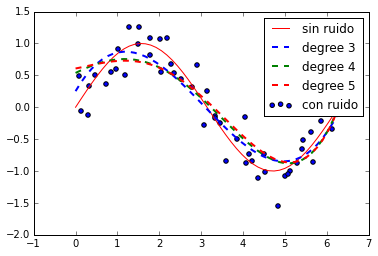

In [17]:
f, ax = plt.subplots()
ax.plot(x, np.sin(x), 'r', label='sin ruido')
ax.scatter(xr, yr, label='con ruido')

X = xr[:, np.newaxis]

for degree in [3, 4, 5]:
    model = make_pipeline(PolynomialFeatures(degree), Ridge())
    model.fit(X, y)
    y = model.predict(x[:, np.newaxis])
    ax.plot(x, y, '--', lw=2, label="degree %d" % degree)
    
ax.legend()

Acabamos de utilizar un modelo `Ridge` que implementa regularización, pero sin optimizar. ¿Qué pasaría si optimizamos el parámetro de regularización $\alpha$ con `RidgeCV`?

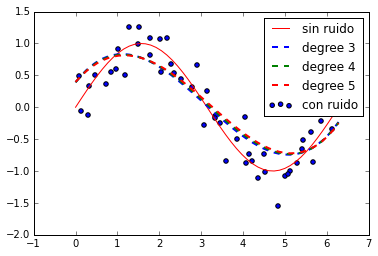

In [18]:
f, ax = plt.subplots()
ax.plot(x, np.sin(x), 'r', label='sin ruido')
ax.scatter(xr, yr, label='con ruido')

X = xr[:, np.newaxis]

for degree in [3, 4, 5]:
    model = make_pipeline(PolynomialFeatures(degree), RidgeCV(alphas=alphas))
    model.fit(X, y)
    y = model.predict(x[:, np.newaxis])
    ax.plot(x, y, '--', lw=2, label="degree %d" % degree)
    
ax.legend()

Si comparamos esta última gráfica con la anterior vemos que ahora las predicciones se han igualado entre si ofreciendo los polinomios de diferente grado predicciones prácticamente idénticas. Eso es porque la regularización tiende a penalizar la complejidad de los modelos tratando de evitar el sobreajuste (*overfitting*).